In [1]:
import mercantile
from shapely.geometry import box, Polygon
import h3
from h3ronpy import vector, util
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy

ERROR 1: PROJ: proj_create_from_database: Open of /home/biel/miniconda3/envs/landgriffon/share/proj failed


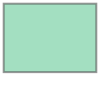

In [33]:
tile_box = box(*mercantile.bounds(mercantile.Tile(1, 1, 2)))
tile_box

In [3]:
def plot_world(box: Polygon, h3s: gpd.GeoDataFrame | None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=cartopy.crs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND)
    ax.add_geometries([box], crs=cartopy.crs.PlateCarree(), facecolor='none', edgecolor='red')
    ax.set_extent([box.bounds[0] - 5, box.bounds[2] + 5, box.bounds[1] - 5, box.bounds[3] + 5])
    if h3s is not None:
        h3s.plot(ax=ax, facecolor='none', edgecolor='blue')

In [14]:
%%time
h3s = h3.polygon_to_cells(h3.Polygon(tile_box.__geo_interface__['coordinates'][0]), 6)
# gdf = gpd.GeoDataFrame(geometry=[Polygon(h3.cell_to_boundary(h, geo_json=True)) for h in h3s])

CPU times: user 97.7 ms, sys: 216 µs, total: 98 ms
Wall time: 97 ms


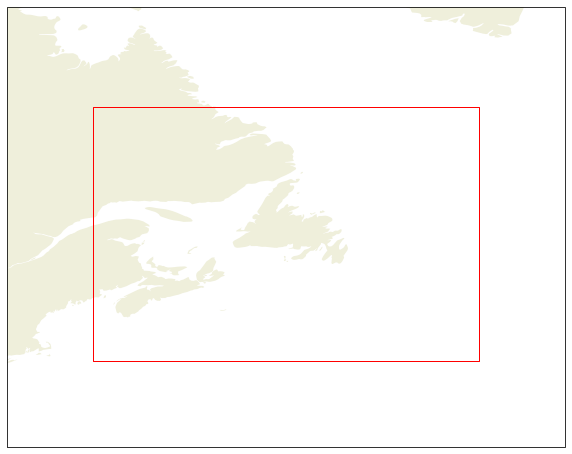

In [6]:
plot_world(tile_box, gdf)

In [19]:
def h3ron_polyfill_method(tile_box: Polygon, h3_res: int) -> gpd.GeoDataFrame:
    gdf = vector.geodataframe_to_h3(gpd.GeoDataFrame(geometry=[tile_box]), h3_res)
    gdf["geometry"] = gdf.h3index.apply(lambda x: Polygon(h3.cell_to_boundary(hex(x)[2:], geo_json=True)))
    return gpd.GeoDataFrame(gdf)

In [34]:
%%time
df = h3ron_polyfill_method(tile_box, 1)

CPU times: user 7.23 ms, sys: 0 ns, total: 7.23 ms
Wall time: 6.58 ms


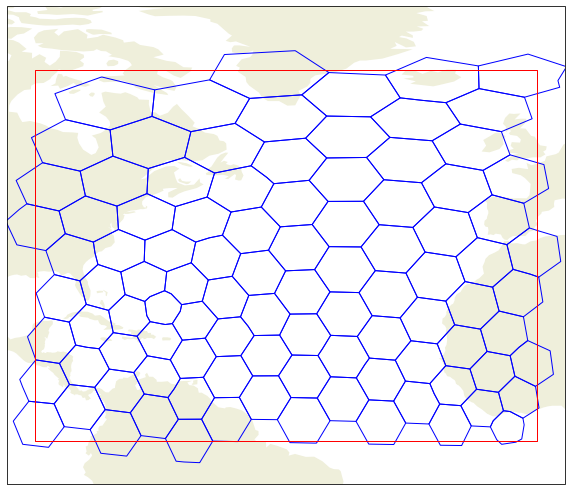

In [35]:
plot_world(tile_box, df)

In [200]:
def get_all_childrens(tile_box: Polygon, h3_res: int) -> list:
    parent_h3s = h3.polygon_to_cells(h3.Polygon(tile_box.__geo_interface__['coordinates'][0]), 0)
    childrens = set()
    for h3s in parent_h3s:
        childrens.update(h3.cell_to_children(h3s, h3_res))
    return childrens

In [201]:
%%time
h3_index = get_all_childrens(tile_box, 4)
gdf = gpd.GeoDataFrame(geometry=[Polygon(h3.cell_to_boundary(h, geo_json=True)) for h in h3_index])

CPU times: user 2.57 ms, sys: 195 µs, total: 2.76 ms
Wall time: 2.49 ms


/home/biel/miniconda3/envs/landgriffon/lib/python3.11/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


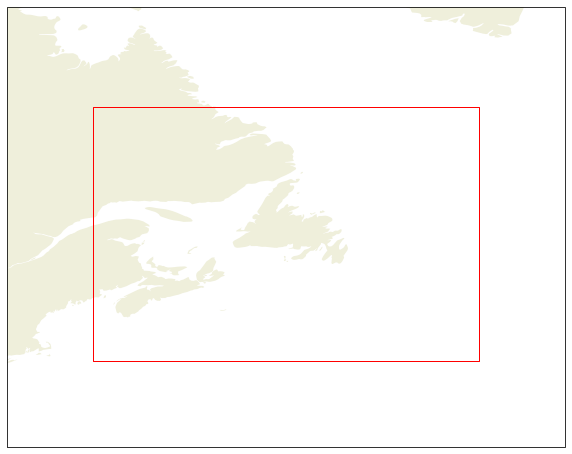

In [202]:
plot_world(tile_box, gdf)